# Advanced Encryption Standard

Advanced Encryption Standard (AES) to symetryczny szyfr blokowy, następca szyfru DES. Został opublikowany po raz pierwszy w 1998 roku, a w 2001 został przyjęty jako standard.

AES jest oparty na algorytmie Rijndaela, którego autorami są belgijscy kryptografowie, Joan Daemen i Vincent Rijmen. 
Zaprezentowali oni swoją propozycję szyfru Instytucji NIST w ramach ogłoszonego konkursu.
NIST wybrał trzy algorytmy z rodziny Rijndaela, z których każdy miał tę samą wielkość bloku (128 bitów), ale miały różne długości klucza: 128, 192 i 256 bitów.

AES jest pierwszym (i jedynym) dostępnym publicznie szyfrem, który był zatwierdzony i wykorzystywany przez NSA do ochrony ściśle tajnych informacji.
W tym tutorialu zostanie przedstawiony wariant AES z kluczem o długości 128 bitów.

In [1]:
def binary_to_decimal(binarybits):
    """ Convert binary bits to decimal """
    decimal = int(binarybits, 2)
    return decimal

def decimal_to_binary(decimal):
    """ Convert decimal to binary bits """
    binary4bits = bin(decimal)[2:].zfill(8)
    return binary4bits

def bytes_to_matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix. """
    bytes_table = [text[i:i+8] for i in range(0, len(text), 8)]
    return [bytes_table[i:i+4] for i in range(0, 16, 4)]

def hex_to_binary(hex_code):
    """ Converts hex number into binary string such that (len(bin_string) % 8 == 0) """
    bin_code = bin( hex_code )[2:]
    padding = (8 - len(bin_code)%8)%8
    return '0' * padding + bin_code


## Rozszerzanie klucza
Pierwszym krokiem w implementacji AES o rozmiarze klucza 128 bitów jest rozszerzenie klucza do 176 bajtów.

## AES key schedule
Key schedule produkuje klucze rundy z pierwotnego krótkiego klucza (128-bitowego).
Rc - stała rundy (round constant)

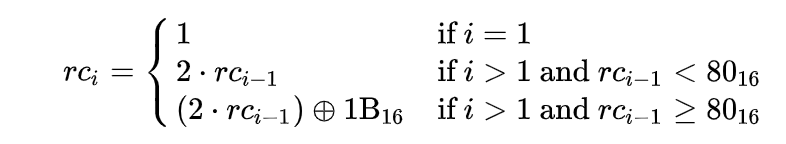

In [2]:
#Iterative version
# i --> in dec
def rcon(i):
    c = 1
    if i == 1:
        return 1
    while i != 1:
        b = c * 2
    
        if c >= 0x80:
            b = b ^ 0x1B
            b = b % 256
        c = b
        i = i-1
    return b

val = rcon(10)    
print("Dec:", val, "hex:", hex(val))  

Dec: 54 hex: 0x36


## **Ciało skończone Galois**

W ciele skończonym Galois są zdefiniowane operacje dodawania, odejmowania, mnożenia i dzielenia (z wyjątkiem dzielenia przez 0), które zwracają ośmiobitowe wyniki.
AES używa mnożenia (gmul) i operacji odwrotnej. 

#### Gmul Mnożenie

Schemat:
1. Weź dwie ośmiobitowe liczby a, b i iloczyn p
2. p = 0
3. Pętla (8 razy)
    * Jeżeli najmniej znaczący bit (low bit) == 1 to p = p ^ a
    * Przesuń a o jeden bit w lewo, usuwając najbardziej znaczący bit (high bit) i ustawiajac najmniej znaczący bit na 0 
    * Jeśli przed przesunięciem bitowym (w poprzednim kroku) najbardziej znaczący bit a był ustawiony na 1 to a = a ^ 0x1b
    * Przesuń b o jeden bit w prawo, usuwając najmniej znaczący bit i ustawiając najbardziej znaczący bit na 0.
4. Zwróć p 

In [3]:
def gmul(a, b):
    p = 0
    for i in range(8):
        if b & 1 == 1:
            p = p ^ a
        prev_a = a
        a = (a << 1) % 256
        
        hi_bit_set = prev_a & 0x80   #0x80 --> 10000000
        if hi_bit_set == 0x80:
            a = a ^ 0x1b
        b = b >> 1 
    return p
       
gmul(7, 3)   

9

In [4]:
ltable = [
0x00, 0xff, 0xc8, 0x08, 0x91, 0x10, 0xd0, 0x36, 
0x5a, 0x3e, 0xd8, 0x43, 0x99, 0x77, 0xfe, 0x18, 
0x23, 0x20, 0x07, 0x70, 0xa1, 0x6c, 0x0c, 0x7f, 
0x62, 0x8b, 0x40, 0x46, 0xc7, 0x4b, 0xe0, 0x0e, 
0xeb, 0x16, 0xe8, 0xad, 0xcf, 0xcd, 0x39, 0x53, 
0x6a, 0x27, 0x35, 0x93, 0xd4, 0x4e, 0x48, 0xc3, 
0x2b, 0x79, 0x54, 0x28, 0x09, 0x78, 0x0f, 0x21, 
0x90, 0x87, 0x14, 0x2a, 0xa9, 0x9c, 0xd6, 0x74, 
0xb4, 0x7c, 0xde, 0xed, 0xb1, 0x86, 0x76, 0xa4, 
0x98, 0xe2, 0x96, 0x8f, 0x02, 0x32, 0x1c, 0xc1, 
0x33, 0xee, 0xef, 0x81, 0xfd, 0x30, 0x5c, 0x13, 
0x9d, 0x29, 0x17, 0xc4, 0x11, 0x44, 0x8c, 0x80, 
0xf3, 0x73, 0x42, 0x1e, 0x1d, 0xb5, 0xf0, 0x12, 
0xd1, 0x5b, 0x41, 0xa2, 0xd7, 0x2c, 0xe9, 0xd5, 
0x59, 0xcb, 0x50, 0xa8, 0xdc, 0xfc, 0xf2, 0x56, 
0x72, 0xa6, 0x65, 0x2f, 0x9f, 0x9b, 0x3d, 0xba, 
0x7d, 0xc2, 0x45, 0x82, 0xa7, 0x57, 0xb6, 0xa3, 
0x7a, 0x75, 0x4f, 0xae, 0x3f, 0x37, 0x6d, 0x47, 
0x61, 0xbe, 0xab, 0xd3, 0x5f, 0xb0, 0x58, 0xaf, 
0xca, 0x5e, 0xfa, 0x85, 0xe4, 0x4d, 0x8a, 0x05, 
0xfb, 0x60, 0xb7, 0x7b, 0xb8, 0x26, 0x4a, 0x67, 
0xc6, 0x1a, 0xf8, 0x69, 0x25, 0xb3, 0xdb, 0xbd, 
0x66, 0xdd, 0xf1, 0xd2, 0xdf, 0x03, 0x8d, 0x34, 
0xd9, 0x92, 0x0d, 0x63, 0x55, 0xaa, 0x49, 0xec, 
0xbc, 0x95, 0x3c, 0x84, 0x0b, 0xf5, 0xe6, 0xe7, 
0xe5, 0xac, 0x7e, 0x6e, 0xb9, 0xf9, 0xda, 0x8e, 
0x9a, 0xc9, 0x24, 0xe1, 0x0a, 0x15, 0x6b, 0x3a, 
0xa0, 0x51, 0xf4, 0xea, 0xb2, 0x97, 0x9e, 0x5d, 
0x22, 0x88, 0x94, 0xce, 0x19, 0x01, 0x71, 0x4c, 
0xa5, 0xe3, 0xc5, 0x31, 0xbb, 0xcc, 0x1f, 0x2d, 
0x3b, 0x52, 0x6f, 0xf6, 0x2e, 0x89, 0xf7, 0xc0, 
0x68, 0x1b, 0x64, 0x04, 0x06, 0xbf, 0x83, 0x38 ]


atable = [
0x01, 0xe5, 0x4c, 0xb5, 0xfb, 0x9f, 0xfc, 0x12, 
0x03, 0x34, 0xd4, 0xc4, 0x16, 0xba, 0x1f, 0x36, 
0x05, 0x5c, 0x67, 0x57, 0x3a, 0xd5, 0x21, 0x5a, 
0x0f, 0xe4, 0xa9, 0xf9, 0x4e, 0x64, 0x63, 0xee, 
0x11, 0x37, 0xe0, 0x10, 0xd2, 0xac, 0xa5, 0x29, 
0x33, 0x59, 0x3b, 0x30, 0x6d, 0xef, 0xf4, 0x7b, 
0x55, 0xeb, 0x4d, 0x50, 0xb7, 0x2a, 0x07, 0x8d, 
0xff, 0x26, 0xd7, 0xf0, 0xc2, 0x7e, 0x09, 0x8c, 
0x1a, 0x6a, 0x62, 0x0b, 0x5d, 0x82, 0x1b, 0x8f, 
0x2e, 0xbe, 0xa6, 0x1d, 0xe7, 0x9d, 0x2d, 0x8a, 
0x72, 0xd9, 0xf1, 0x27, 0x32, 0xbc, 0x77, 0x85, 
0x96, 0x70, 0x08, 0x69, 0x56, 0xdf, 0x99, 0x94, 
0xa1, 0x90, 0x18, 0xbb, 0xfa, 0x7a, 0xb0, 0xa7, 
0xf8, 0xab, 0x28, 0xd6, 0x15, 0x8e, 0xcb, 0xf2, 
0x13, 0xe6, 0x78, 0x61, 0x3f, 0x89, 0x46, 0x0d, 
0x35, 0x31, 0x88, 0xa3, 0x41, 0x80, 0xca, 0x17, 
0x5f, 0x53, 0x83, 0xfe, 0xc3, 0x9b, 0x45, 0x39, 
0xe1, 0xf5, 0x9e, 0x19, 0x5e, 0xb6, 0xcf, 0x4b, 
0x38, 0x04, 0xb9, 0x2b, 0xe2, 0xc1, 0x4a, 0xdd, 
0x48, 0x0c, 0xd0, 0x7d, 0x3d, 0x58, 0xde, 0x7c, 
0xd8, 0x14, 0x6b, 0x87, 0x47, 0xe8, 0x79, 0x84, 
0x73, 0x3c, 0xbd, 0x92, 0xc9, 0x23, 0x8b, 0x97, 
0x95, 0x44, 0xdc, 0xad, 0x40, 0x65, 0x86, 0xa2, 
0xa4, 0xcc, 0x7f, 0xec, 0xc0, 0xaf, 0x91, 0xfd, 
0xf7, 0x4f, 0x81, 0x2f, 0x5b, 0xea, 0xa8, 0x1c, 
0x02, 0xd1, 0x98, 0x71, 0xed, 0x25, 0xe3, 0x24, 
0x06, 0x68, 0xb3, 0x93, 0x2c, 0x6f, 0x3e, 0x6c, 
0x0a, 0xb8, 0xce, 0xae, 0x74, 0xb1, 0x42, 0xb4, 
0x1e, 0xd3, 0x49, 0xe9, 0x9c, 0xc8, 0xc6, 0xc7, 
0x22, 0x6e, 0xdb, 0x20, 0xbf, 0x43, 0x51, 0x52, 
0x66, 0xb2, 0x76, 0x60, 0xda, 0xc5, 0xf3, 0xf6, 
0xaa, 0xcd, 0x9a, 0xa0, 0x75, 0x54, 0x0e, 0x01 ]
            
    
def gmul_inverse(i):
    if i == 0:
        return 0
    else:
        return atable[(255 - ltable[i])];
       
gmul_inverse(9)

79

In [22]:
#Calculate the s-box for a given number
def sbox(i):
    val = gmul_inverse(i)
    s = val
    x = val
    for k in range(4):
        #One bit circular rotate to the left
        s = (s << 1) % 256 | (s >> 7)
        x = x ^ s
    x = x ^ 99 #0x63
    return x
        
print(sbox(int("ef", 16)) == SBOX[int("ef", 16)])
print(sbox(int("ee", 16)) == SBOX[int("ee", 16)])
print(sbox(int("a", 16)) == SBOX[int("a", 16)])

True
True
True


In [6]:
SBOX = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]


INV_SBOX = [
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
]   

In [7]:
def rotate_32bits_word(word):
    return word[8:32] + word[0:8]

rotate_32bits_word("00000000111111110111111101010101")

'11111111011111110101010100000000'

In [8]:
def schedule_core(v, i):
    #Rotate the input 8 bits to the left
    v = rotate_32bits_word(v)
    out = ""
    #Apply Rijndael's s-box on all 4 bytes
    for n in range(4):
        n_byte = v[n*8:n*8+8]
        out = out + decimal_to_binary(sbox(binary_to_decimal(n_byte)))
    
    first_byte = out[0:8]
    #On just the first byte, add 2^i to the byte
    xor = binary_to_decimal(first_byte) ^ rcon(i)
    out = decimal_to_binary(xor) + out[8:32]
    return out
    
print(schedule_core("00000000111111110111111101010101", 2))
print(schedule_core("00000000111111110111111101010101", 11))


00010100110100101111110001100011
01111010110100101111110001100011


In [9]:
def expand_key(key_128_bits):
    bytes_number = 128 / 8   # 16
    key_as_16_bytes = []
    n =  1
    
    for i in range(0, 128, 8):
        key_as_16_bytes.append(key_128_bits[i: i+8])
    

    t = key_as_16_bytes
    expanded_key = []
    expanded_key = key_as_16_bytes
    i = 16
    while i < 176:
        #last four bytes 
        t = expanded_key[-4:]
        
        if i % 16 == 0:
            x = schedule_core(t[0]+t[1]+t[2]+t[3], n)           
            t = []
            for k in range(0, 128, 8):
                t.append(x[k: k+8])
            n = n + 1
            
        for k in range(4):
            expanded_key.append(XOR(t[k], expanded_key[i - 16]))
            i = i + 1
        
    return expanded_key
        
            
            
def XOR(bits1,bits2):
    """perform a XOR operation and return the output"""
    # Assuming both bit string of same length
    xor_result = ""
    for index in range(len(bits1)):
        if bits1[index] == bits2[index]: 
            xor_result += '0'
        else:
            xor_result += '1'
    return xor_result            

def hex_key_to_binary_128_bits(hex_text):
    bin_text = hex_to_binary(hex_text)
    padding = (128-len(bin_text))%128
    bin_text = '0' * padding + bin_text
    return bin_text
    
    

hex_key = 0x000102030405060708090a0b0c0d0e0f
#hex_key = 0xffffffffffffffffffffffffffffffff
#hex_key = 0x00000000000000000000000000000000 
bin_key = hex_key_to_binary_128_bits(hex_key)

list(map(lambda x: hex(int(x, 2)), expand_key(bin_key)))

['0x0',
 '0x1',
 '0x2',
 '0x3',
 '0x4',
 '0x5',
 '0x6',
 '0x7',
 '0x8',
 '0x9',
 '0xa',
 '0xb',
 '0xc',
 '0xd',
 '0xe',
 '0xf',
 '0xd6',
 '0xaa',
 '0x74',
 '0xfd',
 '0xd2',
 '0xaf',
 '0x72',
 '0xfa',
 '0xda',
 '0xa6',
 '0x78',
 '0xf1',
 '0xd6',
 '0xab',
 '0x76',
 '0xfe',
 '0xb6',
 '0x92',
 '0xcf',
 '0xb',
 '0x64',
 '0x3d',
 '0xbd',
 '0xf1',
 '0xbe',
 '0x9b',
 '0xc5',
 '0x0',
 '0x68',
 '0x30',
 '0xb3',
 '0xfe',
 '0xb6',
 '0xff',
 '0x74',
 '0x4e',
 '0xd2',
 '0xc2',
 '0xc9',
 '0xbf',
 '0x6c',
 '0x59',
 '0xc',
 '0xbf',
 '0x4',
 '0x69',
 '0xbf',
 '0x41',
 '0x47',
 '0xf7',
 '0xf7',
 '0xbc',
 '0x95',
 '0x35',
 '0x3e',
 '0x3',
 '0xf9',
 '0x6c',
 '0x32',
 '0xbc',
 '0xfd',
 '0x5',
 '0x8d',
 '0xfd',
 '0x3c',
 '0xaa',
 '0xa3',
 '0xe8',
 '0xa9',
 '0x9f',
 '0x9d',
 '0xeb',
 '0x50',
 '0xf3',
 '0xaf',
 '0x57',
 '0xad',
 '0xf6',
 '0x22',
 '0xaa',
 '0x5e',
 '0x39',
 '0xf',
 '0x7d',
 '0xf7',
 '0xa6',
 '0x92',
 '0x96',
 '0xa7',
 '0x55',
 '0x3d',
 '0xc1',
 '0xa',
 '0xa3',
 '0x1f',
 '0x6b',
 '0x14',
 '0xf9'

In [10]:
def mix_one_column(state):
    a = []
    # copy vals to a list and convert each element from bonary to dec 
    for i in range(4):
        dec_state = int(state[i], 2)
        a.append(dec_state)
    
    state[0] = decimal_to_binary(gmul(a[0], 2) ^ gmul(a[3], 1) ^ gmul(a[2], 1) ^ gmul(a[1], 3))
    state[1] = decimal_to_binary(gmul(a[1], 2) ^ gmul(a[0], 1) ^ gmul(a[3], 1) ^ gmul(a[2], 3))
    state[2] = decimal_to_binary(gmul(a[2], 2) ^ gmul(a[1], 1) ^ gmul(a[0], 1) ^ gmul(a[3], 3))
    state[3] = decimal_to_binary(gmul(a[3], 2) ^ gmul(a[2], 1) ^ gmul(a[1], 1) ^ gmul(a[0], 3))

    
def mix_columns(state):
    for i in range(4):
        mix_one_column(state[i])


def inv_mix_one_column(state):
    a = []
    # copy vals to a list and convert each element from bonary to dec 
    for i in range(4):
        dec_state = int(state[i], 2)
        a.append(dec_state)
    
    state[0] = decimal_to_binary(gmul(a[0], 14) ^ gmul(a[3], 9) ^ gmul(a[2], 13) ^ gmul(a[1], 11))
    state[1] = decimal_to_binary(gmul(a[1], 14) ^ gmul(a[0], 9) ^ gmul(a[3], 13) ^ gmul(a[2], 11))
    state[2] = decimal_to_binary(gmul(a[2], 14) ^ gmul(a[1], 9) ^ gmul(a[0], 13) ^ gmul(a[3], 11))
    state[3] = decimal_to_binary(gmul(a[3], 14) ^ gmul(a[2], 9) ^ gmul(a[1], 13) ^ gmul(a[0], 11))
    
    
        
def inv_mix_columns(state):
    for i in range(4):
        inv_mix_one_column(state[i])

#example           
state = [['11011011', '00010011', '01010011', '01000101'], 
         ['01100100', '00000111', '00000001', '01100010'], 
         ['00010010', '10000000', '10111111', '01111110'], 
         ['11001110', '00101100', '00000101', '11010011']]

mix_columns(state)
inv_mix_columns(state)
print(state)

[['11011011', '00010011', '01010011', '01000101'], ['01100100', '00000111', '00000001', '01100010'], ['00010010', '10000000', '10111111', '01111110'], ['11001110', '00101100', '00000101', '11010011']]


In [11]:
def bytes_to_matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix.  """
    bytes_table = [text[i:i+8] for i in range(0, len(text), 8)]
    #return bytes_table
    return [bytes_table[i:i+4] for i in range(0, 16, 4)]

#substitute all bytes using Rijndael's substitution box 
def sub_bytes(state):
    for i in range(4):
        for j in range(4):
            dec_state = int(state[i][j], 2)
            state[i][j] = decimal_to_binary(SBOX[dec_state])

#reverse the sub bytes step using Rijndael's inverse s-box 
def inv_sub_bytes(state):
    for i in range(4):
        for j in range(4):
            dec_state = int(state[i][j], 2)
            state[i][j] = decimal_to_binary(INV_SBOX[dec_state])
            
            
def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]


def inv_shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[3][1], s[0][1], s[1][1], s[2][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[1][3], s[2][3], s[3][3], s[0][3]

    
#add the round key to the state with simple XOR operation  
def add_round_key(state, round_key):
    for i in range(4):
        for j in range(4):
            state[i][j] = XOR(state[i][j], round_key[i*4+j])
       
                       
#Encrypts a single block of 16 byte long plaintext
def aes128_encrypt(plain_text, key_128_bits):
    key_schedule = expand_key(key_128_bits)
    # 4x4 grid 
    plain_state = bytes_to_matrix(plain_text)

    # first 16 bytes  1x16
    round_keys = key_schedule[:16]
    
    #initial round of AddRoundKey step 
    add_round_key(plain_state, round_keys)

    
    #rounds 1-9 of the algorithm
    for i in range(9): 
        sub_bytes(plain_state)
        shift_rows(plain_state)
        mix_columns(plain_state)
        
        for j in range(16):
            round_keys[j] = key_schedule[j + (i+1)*16]
        
        add_round_key(plain_state, round_keys)
        
    #final round
    #prepare final round key  
    #last 16 bytes
    round_keys = key_schedule[-16:]

  
    # final round of the algorithm
    sub_bytes(plain_state);
    shift_rows(plain_state);
    add_round_key(plain_state, round_keys)
    return plain_state

#Decrypts a single block of 16 byte long plaintext
def aes128_decrypt(cipher_text, key_128_bits):
    key_schedule = expand_key(key_128_bits)
    # 4x4 grid 
    state = bytes_to_matrix(cipher_text)

    # first 16 bytes  1x16
    round_keys = key_schedule[-16:]
    
    #initial round of AddRoundKey step 
    add_round_key(state, round_keys)
  
    
    #rounds 1-9 of the algorithm
    for i in range(9): 
        inv_shift_rows(state)
        inv_sub_bytes(state)
        
        for j in range(16):
            key_schedule[j + ((176 - 16) - i * 16)];
            round_keys[j] = key_schedule[j + (176-16 - (i+1)*16)]
        
        add_round_key(state, round_keys)
        inv_mix_columns(state)
        
        
    #final round
    #prepare final round key  
    #first 16 bytes
    round_keys = key_schedule[:16]
  
    # final round of the algorithm
    inv_shift_rows(state);
    inv_sub_bytes(state);
    add_round_key(state, round_keys)
    return state
 
    
plain_text = 0x00000000000000000000000000000000
hex_key = 0xffffffffffffffffffffffffffffffff
bin_key = hex_key_to_binary_128_bits(hex_key)
bin_plaintext = hex_key_to_binary_128_bits(plain_text)

ciphertext_list = aes128_encrypt(bin_plaintext, bin_key)
flat_list = [item for sublist in ciphertext_list for item in sublist]
print("Szyfrogram:", list(map(lambda x: hex(int(x, 2)), flat_list)))

ciphertext = "".join(flat_list)
plaintext_list = aes128_decrypt(ciphertext, bin_key)
flat_list = [item for sublist in plaintext_list for item in sublist]
print("Tekst jawny:", list(map(lambda x: hex(int(x, 2)), flat_list)))

Szyfrogram: ['0xa1', '0xf6', '0x25', '0x8c', '0x87', '0x7d', '0x5f', '0xcd', '0x89', '0x64', '0x48', '0x45', '0x38', '0xbf', '0xc9', '0x2c']
Tekst jawny: ['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
